# Generate SWAN wave spectra over a scene with currents

### imports

In [1]:
#import wavespectra
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.io as io
from stereoid.oceans.waves.wave_spectra import spec_peak
import netCDF4 as nc
from stereoid.oceans.waves.wave_spectra import elfouhaily
import xarray as xr
from drama import utils as drtls

### settings and folder

In [2]:
# path to swan installation
#dir_setup = os.path.join()
swan_dir='/data1/marcel/swan/swan4131/'

# paths for ocean model
scn_dir =  '/data1/marcel/Harmony/data/ocean/'
scn_file = scn_dir + 'DALES/Dales_36_hrs_12_01_00_surface_winds.nc'

# path to store the output
output_dir='/data1/marcel/Harmony/RESULTS/SWAN/DALES/'

### read ocean model output and crop

In [3]:
def dummy_wind_adjustment(u_in, v_in):
    return 0.95 * u_in, 0.95 * v_in

def read_scenario_DALES_KNMI(ncfile, smp_out=500, wind_adjustment_func=dummy_wind_adjustment, SST0=292,
                             rot_angle=0, add_margin=22E3):
    swind = xr.open_dataset(ncfile)
    dx =1e3*(swind.cross_track.values[1] - swind.cross_track.values[0])
    u = np.flip(np.transpose(swind.U10.values), axis=1)
    v = np.flip(np.transpose(swind.V10.values), axis=1)
    z = np.flip(np.transpose(swind.Wind_height.values), axis=1)
    u, v = wind_adjustment_func(u, v)
    w = np.flip(np.transpose(swind.w10.values), axis=1)
    lat = np.flip(np.transpose(swind.latitude.values), axis=1)
    lon = np.flip(np.transpose(swind.longitude.values), axis=1)
    if int(np.floor(smp_out/dx)) > 1:
        dec = int(np.floor(smp_out/dx))
        smp_out = dec * dx
        smp0 = int(dec/2)
        u = drtls.smooth(u, dec)
        v = drtls.smooth(v, dec)
        w = drtls.smooth(w, dec)
        u=u[smp0:-1:dec, smp0:-1:dec]
        v=v[smp0:-1:dec, smp0:-1:dec]
        w=w[smp0:-1:dec, smp0:-1:dec]
        lat=lat[smp0:-1:dec, smp0:-1:dec]
        lon=lon[smp0:-1:dec, smp0:-1:dec]

    if int(add_margin/smp_out) > 0:
        shp = u.shape
        asmpl = int(add_margin/smp_out)
        shp_out = (shp[0] + 2 * asmpl,
                   shp[1]+  2 * asmpl)
        u_ = np.zeros(shp_out) + np.mean(u)
        u_[asmpl:asmpl+shp[0], asmpl:asmpl+shp[1]] = u
        u = u_
        v_ = np.zeros(shp_out) + np.mean(v)
        v_[asmpl:asmpl+shp[0], asmpl:asmpl+shp[1]] = v
        v = v_

        lat_ = np.arange(shp_out[0]) * (lat[1,0] - lat[0,0])
        lat = lat_.reshape((shp_out[0],1)) + np.zeros_like(u) - lat_[asmpl] + lat[0,0]
        lon_ = np.arange(shp_out[1]) * (lon[0,1] - lon[0,0])
        lon = lon_.reshape((1,shp_out[1])) + np.zeros_like(u) - lon_[asmpl] + lon[0,0]

    wind_v = np.stack([u,v], axis=-1)
    tsc_v = np.zeros_like(wind_v)
    sst = np.zeros_like(u) + SST0

    if rot_angle != 0:
        wind_v[np.isnan(wind_v)] = 0
        tsc_v[np.isnan(tsc_v)] = 0
        sst[np.isnan(sst)] = 25
        wind_v = np.stack([ndimage.rotate(wind_v[:, :, 0], rot_angle),
                           ndimage.rotate(wind_v[:, :, 1], rot_angle)], axis=-1)
        tsc_v = np.stack([ndimage.rotate(tsc_v[:, :, 0], rot_angle),
                          ndimage.rotate(tsc_v[:, :, 1], rot_angle)], axis=-1)
        sst = ndimage.rotate(sst, rot_angle)
        lat = ndimage.rotate(lat, rot_angle)
        lon = ndimage.rotate(lon, rot_angle)
        rot_m = np.array([[np.cos(np.radians(rot_angle)), np.sin(np.radians(rot_angle))],
                          [-np.sin(np.radians(rot_angle)), np.cos(np.radians(rot_angle))]])
        wind_v = np.einsum("lk,ijk->ijl", rot_m, wind_v)
        tsc_v = np.einsum("lk,ijk->ijl", rot_m, tsc_v)


    dic_out = {'tsc': tsc_v, 'wnd': wind_v, 'sst': sst,
               'lon': lon, 'lat': lat, 'grid_spacing': smp_out}
    return dic_out, smp_out


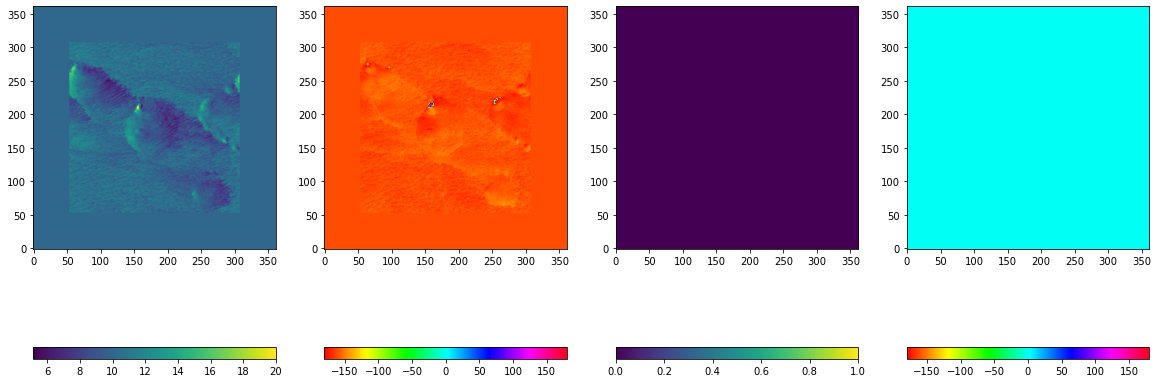

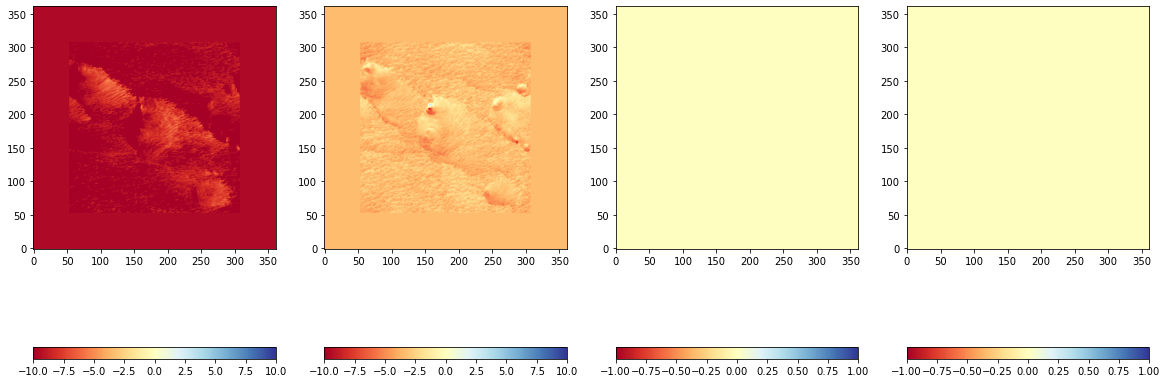

In [4]:
# read data
ds,smp_out=read_scenario_DALES_KNMI(scn_file)
shp=ds['tsc'].shape

wind=np.zeros((shp[0],shp[1],2))
tsc=np.zeros((shp[0],shp[1],2))
sst=np.zeros((shp[0],shp[1]))

# atmosphere and ocean parameters
wind[:,:,0]=ds['wnd'][:,:,0]
wind[:,:,1]=ds['wnd'][:,:,1]
tsc[:,:,0]=ds['tsc'][:,:,0]
tsc[:,:,1]=ds['tsc'][:,:,1]
sst=ds['sst'][:,:]

# crop data
#Ix=range(50,190)
#wind=wind[:,Ix,:]
#tsc=tsc[:,Ix,:]
#sst=sst[:,Ix]
#shp=sst.shape

# x and y (which is a guess)
dx=smp_out*1.0
dy=smp_out*1.0
xs=np.arange(0,shp[1]*dx,dx)
ys=np.arange(0,shp[0]*dy,dy)

# bathymetry
depth=1000
bath=np.ones((shp[0],shp[1]))*depth


plt.figure(figsize=(20,12))
plt.subplot(1,4,1)
plt.imshow(np.sqrt(wind[:,:,0]**2+wind[:,:,1]**2),origin='lower',vmax=20)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,2)
plt.imshow(np.rad2deg(np.arctan2(wind[:,:,1],wind[:,:,0])),vmin=-180,vmax=180, origin='lower',cmap='hsv')
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,3)
plt.imshow(np.sqrt(tsc[:,:,0]**2+tsc[:,:,1]**2),origin='lower',vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,4)
plt.imshow(np.rad2deg(np.arctan2(tsc[:,:,1],tsc[:,:,0])),vmin=-180,vmax=180, origin='lower',cmap='hsv')
plt.colorbar(orientation='horizontal')
plt.figure(figsize=(20,12))
plt.subplot(1,4,1)
plt.imshow(wind[:,:,0],origin='lower',cmap='RdYlBu',vmin=-10,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,2)
plt.imshow(wind[:,:,1], origin='lower',cmap='RdYlBu',vmin=-10,vmax=10)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,3)
plt.imshow(tsc[:,:,0],origin='lower',cmap='RdYlBu',vmin=-1,vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,4,4)
plt.imshow(tsc[:,:,1], origin='lower',cmap='RdYlBu',vmin=-1,vmax=1)
plt.colorbar(orientation='horizontal')

### generate a SWAN config file

In [5]:
# some required information and intitial settings
g=9.81
fetch=100E3
u10=np.sqrt(wind[:,:,0]**2+wind[:,:,1]**2)
U_mean=np.mean(u10[sst != 999])
phi_w=np.mod(np.rad2deg(np.arctan2(wind[:,:,1],wind[:,:,0])),360)
kp=spec_peak(U_mean,fetch)
f_max=np.sqrt(g*2*np.pi)/(2*np.pi) # 1 meter
f_min=np.sqrt(g*kp/10)/(2*np.pi)
fp=np.sqrt(g*kp)/(2*np.pi)
print(U_mean)

10.132415865098046


In [6]:
scene='DA1_'
run= 'R02'
bathfile=output_dir + scene + run + '.bath'
currfile=output_dir + scene + run + '.curr'
windfile=output_dir + scene + run + '.wind'
#inispecfile=output_dir + scene + run + '.inispec'
hsfile=output_dir + 'hs' + scene + run + '.mat'
specfile=output_dir + 'spec' + scene + run + '.xarray'
filename=output_dir + scene + run + '.swn'
f=open(filename,'w+')
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('PROJECT \'%s\' \'%s\'\n' % (scene,run))
f.write('SET CART\n')
f.write('NUM STOPC 0.01 0.01 0.01 90\n')
f.write('MODE STAT TWOD\n')
f.write('COORDINATES CART\n')
f.write('$---------------------------------------------------------------------------------------------\n')
#f.write('CGRID REG %d %d %d %d %d %d %d CIR %d %.4f %.4f %d\n' % (0,0,0,np.max(xs),np.max(ys),len(xs)-1,len(ys)-1,20,f_min,f_max,40))
f.write('CGRID REG %d %d %d %d %d %d %d SEC %d %d %d %.4f %.4f %d\n' % (0,0,0,np.max(xs),np.max(ys),len(xs)-1,len(ys)-1,-180,180,60,f_min,f_max,96))
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('INP BOT %d %d %d %d %d %d %d EXC 999. \n' % (0,0,0,len(xs)-1,len(ys)-1,dx,dx))
f.write('INP CUR %d %d %d %d %d %d %d EXC 999. \n' % (0,0,0,len(xs)-1,len(ys)-1,dx,dx))
f.write('INP WI %d %d %d %d %d %d %d EXC 999. \n' % (0,0,0,len(xs)-1,len(ys)-1,dx,dx))
f.write('READ BOT 1 \'%s\' 3 0 FREE\n' % bathfile)
f.write('READ CUR 1 \'%s\' 3 0 FREE\n' % currfile)
f.write('READ WI 1 \'%s\' 3 0 FREE\n' % windfile)
#f.write('WIND %.2f %.2f\n' % (U_in,phi_U))
f.write('$---------------------------------------------------------------------------------------------\n')
#f.write('BOUN SEGM XY %d %d %d %d CON FILE \'%s\' 1\n' % (0,0,0,np.max(ys),inispecfile))
f.write('BOU SHAP JON 3.3 PEAK DSPR DEGR\n')
f.write('BOU SEGM XY %d %d %d %d VAR PAR 20000 %.2f %.2f %.2f %.2f\n' % ((shp[1]-1)*dx, 0, (shp[1]-1)*dx, (shp[0]-1)*dy, 1, 1/fp, np.mean(phi_w), 25))
f.write('BOU SEGM XY %d %d %d %d VAR PAR 20000 %.2f %.2f %.2f %.2f\n' % (0, (shp[0]-1)*dy, (shp[1]-1)*dx, (shp[0]-1)*dy, 1, 1/fp, np.mean(phi_w), 25))
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('GROUP \'OUTPUT\' SUBG %d %d %d %d\n' % (0,len(xs)-1,0,len(ys)-1))
f.write('BLOCK \'OUTPUT\' NOHEAD \'%s\' LAY 3 HS\n' % hsfile)
f.write('SPEC \'OUTPUT\' SPEC2D ABS \'%s\'\n' % specfile)
f.write('$---------------------------------------------------------------------------------------------\n')
f.write('COMPUTE\n')
f.write('STOP\n')
f.close()

### current, bathymetry and initial spectrum

In [7]:
# current file
tsc_stack=np.vstack((tsc[:,:,0]*1,tsc[:,:,1]*1))
np.savetxt(currfile,tsc_stack,fmt='%.2f')
# bath file
np.savetxt(bathfile,bath,fmt='%.2f')
# wind file
wind_stack=np.vstack((wind[:,:,0]*1,wind[:,:,1]*1))
#phi_rad=np.deg2rad(phi_U)
#wind_stack=np.vstack((np.ones(wind[:,:,0].shape)*10,np.ones(wind[:,:,0].shape)*0))
np.savetxt(windfile,wind_stack,fmt='%.2f')
# optional file for initial wave spectrum
### --------

### run SWAN

In [ ]:
os.chdir(output_dir)
os.system('chmod 755 ./*')
comm='cp ./' + scene + '* ' + swan_dir
os.system(comm)
os.chdir(swan_dir)
comm='./swanrun -input \'' + filename + '\''
print(comm)
os.system(comm)

./swanrun -input '/data1/marcel/Harmony/RESULTS/SWAN/DALES/DA1_R02.swn'
swan.exe is ./swan.exe

 SWAN is preparing computation

 iteration    1; sweep 1
+iteration    1; sweep 2
+iteration    1; sweep 3
+iteration    1; sweep 4
 not possible to compute, first iteration

 iteration    2; sweep 1
+iteration    2; sweep 2
+iteration    2; sweep 3
+iteration    2; sweep 4
 accuracy OK in   0.47 % of wet grid points ( 90.00 % required)

 iteration    3; sweep 1
+iteration    3; sweep 2
+iteration    3; sweep 3
+iteration    3; sweep 4
 accuracy OK in   0.07 % of wet grid points ( 90.00 % required)

 iteration    4; sweep 1
+iteration    4; sweep 2
+iteration    4; sweep 3
+iteration    4; sweep 4
 accuracy OK in   0.22 % of wet grid points ( 90.00 % required)

 iteration    5; sweep 1
+iteration    5; sweep 2
+iteration    5; sweep 3
+iteration    5; sweep 4
 accuracy OK in   0.65 % of wet grid points ( 90.00 % required)

 iteration    6; sweep 1
+iteration    6; sweep 2
+iteration    6; sw

### read wave spectra, significant wave height and do some tests

In [ ]:
hsfile=output_dir + 'hs' + scene + run + '.mat'
#specfile=output_dir + 'spec' + scene + run + '.xarray'
hsdata=io.loadmat(hsfile)

In [ ]:
plt.figure(figsize=(5,15))
plt.imshow(hsdata['Hsig'],origin='lower',vmin=0,vmax=2)
plt.colorbar(orientation='horizontal')
plt.xlabel('cross-track [km]')
plt.ylabel('along-track [km]')
plt.title('SWAN')

In [ ]:
np.any(tsc!=tsc)